<center>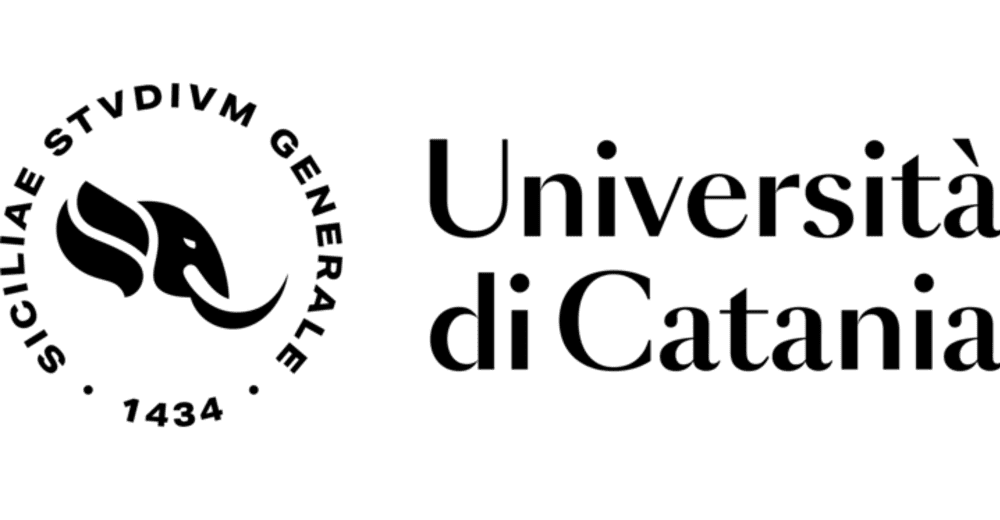

<h1>DATA SCIENCE FOR MANAGEMENT - LM 91</h1>
<h3>Camera Calibration</h3>

# 0. Required libraries
Before starting is useful to install and import required libraries to avoid errors/problems during the runtime

In [1]:
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# 1. What is camera calibration?
The term Camera Calibration[1], or camera resectioning, means estimating the parameters of a lens and image sensor of an image or camera. Using these parameters we can correct the lens distortion, measure the size of an object in world units, or determine the location of the camera in the scene.

# 1.1 How?
Using a checkerboard pattern [2] of 9 rows, 6 columns and a square size of 24 millimeters is possible to calibrate the two cameras.

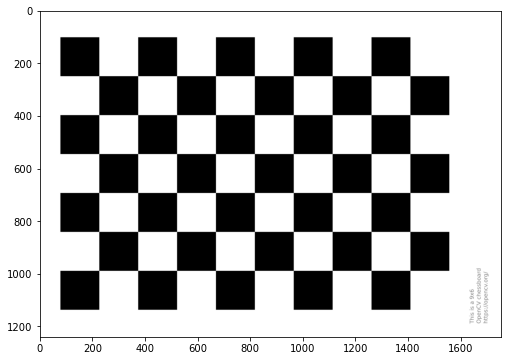

In [2]:
pattern=mpimg.imread("pattern.png")
plt.subplots(figsize=(18, 6))
plt.imshow(pattern)
plt.show()

The checkerboard pattern has been printed and applyied on a white box, then pictures have been taken using two Canon 750d [3], the distance between the two cameras (the baseline) is about 116cm but as you can see from the photographic set the camera on the right has a different angle and also it about 10cm further back than the camera on the left.

The following picture shows the "photographic set":

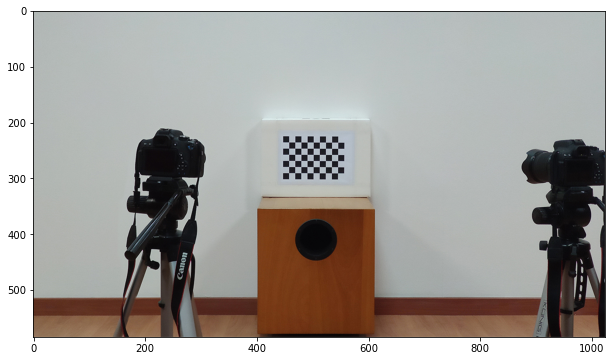

In [3]:
photographic_set=mpimg.imread("photographic_set.jpg")
plt.subplots(figsize=(18, 6))
plt.imshow(photographic_set)
plt.show()

# 1. Data

Taking into consideration different angles, tilt, and so on, we took 14 pictures for each cameras. Data have been renamed has following "left01.jpg" for the first picture from left camera and the same apply for the camera on the right.
Pictures have been resized from the original 6000x4000 to 720x480 to avoid computational bottleneck.

Let's start loading and visualizing two corresponding images, taking into consideration the resolution:

In [4]:
im_left = cv2.imread('left01.jpg')
im_right = cv2.imread('right01.jpg')
print(im_left.shape)
print(im_right.shape)

(480, 720, 3)
(480, 720, 3)


We can now show the two images as follows:

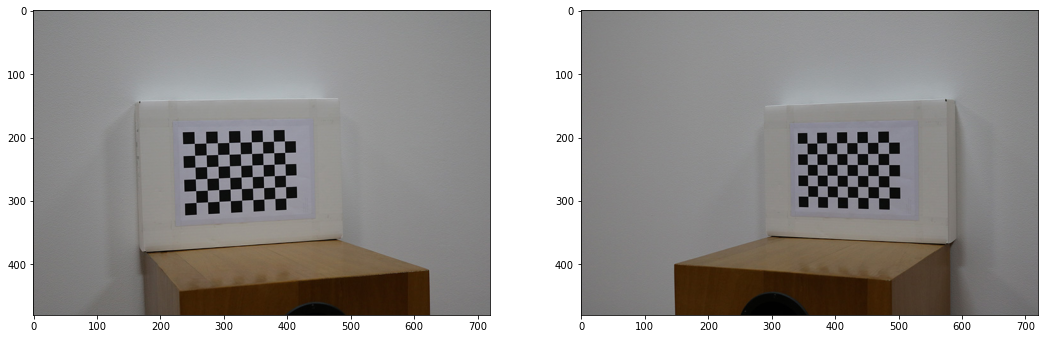

In [5]:
plt.subplots(figsize=(18, 6))
plt.subplot(121)
plt.imshow(im_left[...,::-1])
plt.subplot(122)
plt.imshow(im_right[...,::-1])
plt.show()

# 2. Camera Calibration

Calibrating the camera basically means finding the matrices of intrinsic and extrinsic parameters, so find the correspondences between 3D world points and 2D image points.

\begin{eqnarray}
M_{int}=\left( \begin{array}{ccc}
f_x & 0 & o_x \\
0 & f_y & o_y \\
0 & 0 & 1 \end{array} \right), 
M_{ext}=\left( \begin{array}{cccc}
r_{11} & r_{12} & r_{13} & t_{1} \\
r_{21} & r_{22} & r_{23} & t_{2}\\
r_{31} & r_{32} & r_{33} & t_{3}\end{array} \right)
\end{eqnarray}

## 2.1 Finding Checkerboard Corners

Points can be easily found using the <a href="http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners">cv2.findChessboardCorners</a> function:



In [6]:
ret, corners = cv2.findChessboardCorners(im_left, (9,6))

We had to specify `(9,6)` as `patternSize` parameter to specify the number of **inner** corners in the checkerboard. In practice, we are excluding incomplete rows and columns.

In [7]:
print(ret)
print(corners.shape)

True
(54, 1, 2)


As we can see the `return` value of findChessboardCorners is true, meaning that the checkerboard was detected correctly. The `corners` variable contains $54$ vectors of dimension $1\times2$. Each vector represents the coordinates of a detected corner. For example we can see the values of the first corner as follows:

In [8]:
print(corners[0])

[[254.41129 210.19522]]


As can be noted, `corners[0]` is an array containing an array of two values. To handle the `corners` array more easily, we can reshape it as follows:

In [9]:
corners=corners.reshape(-1,2)
print(corners.shape)
print(corners[0])

(54, 2)
[254.41129 210.19522]


We can now print the corners using the function <a href="http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.drawChessboardCorners">drawChessboardCorners</a>. Since this function would overwrite the content of `img1`, a good idea would be to create a copy for visualization only:

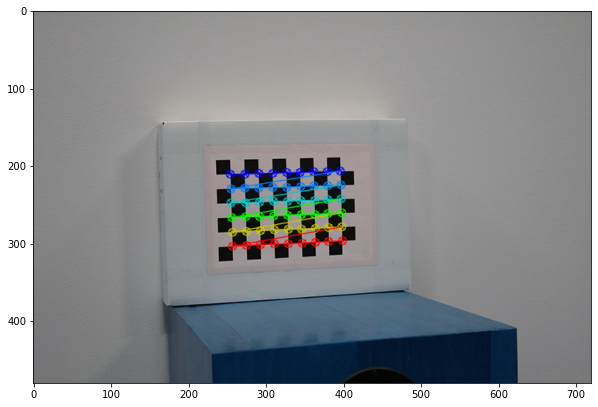

In [10]:
im_left_vis = im_left.copy() # copy by value
cv2.drawChessboardCorners(im_left_vis, (9,6), corners, ret) 
plt.figure(figsize=(10,10))
plt.imshow(im_left_vis)
plt.show()

As can be observed from the image, the $54$ corners are detected from left to right, top to bottom.

## 2.2 Calibration

Now we need to specify a 3D coordinate system for each of the $54$ detected points. To create such array, we first create a <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html">meshgrid</a> which will give us all combinations of X-Y coordinates:

In [11]:
x,y=np.meshgrid(range(9),range(6)) #Return coordinate matrices from coordinate vectors.
print("x:\n",x)
print("y:\n",y)

x:
 [[0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]]
y:
 [[0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5 5 5]]


Basically, every pair of values $(x_{ij},y_{ij})$ represent a point in the X-Y space.

To obtain our vector, we first reshape the matrices `x` and `y` to obtain column vectors. Then, we <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html">stack</a> the vectors vertically and add a vector with 54 zeros. We finally convert the array into an array of floats:

In [12]:
world_points=np.hstack((x.reshape(54,1),y.reshape(54,1),np.zeros((54,1)))).astype(np.float32)
print(world_points[:10])

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [7. 0. 0.]
 [8. 0. 0.]
 [0. 1. 0.]]


We now have our correspondences between 3D and 2D points, i.e., each row of `world_points` corresponds to a row of `corners`. We can show some of these correspondences:

In [13]:
print(corners[0],'->',world_points[0])
print(corners[50],'->',world_points[50])

[254.41129 210.19522] -> [0. 0. 0.]
[346.60657 298.69647] -> [5. 5. 0.]


We could already calibrate our camera using a single image, but this would likely result in an imprecise calibration. Therefore, we need to load all images, finding corners and creating two lists of corresponding 3D and 2D coordinates.

In [14]:
from glob import glob

_3d_points=[]
_2d_points=[]

img_paths=glob('*.jpg') #get paths of all all images
for path in img_paths:
    im=cv2.imread(path)
    ret, corners = cv2.findChessboardCorners(im, (9,6))
    
    if ret: #add points only if checkerboard was correctly detected:
        _2d_points.append(corners) #append current 2D points
        _3d_points.append(world_points) #3D points are always the same

To calibrate the camera, we can use the <a href="http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.calibrateCamera">cv2.calibrateCamera</a> function.

The function returns the following values:
 * `ret`: the mean reprojection error (it should be as close to zero as possible);
 * `mtx`: the matrix of intrisic parameters;
 * `dist`: the distortion parameters;
 * `rvecs`: the rotation vectors (one per image);
 * `tvecs`: the translation vectors (one per image).
 
We need to specify the dimensions of each image in the $width \times height$ format. Since the `shape` attribute contains the number of **rows** and **columns**, the two numbers need to be inverted (rows=height, columns=width), i.e., using `(im1.shape[1],im1.shape[0])` rather than `(im1.shape[0],im1.shape[1])`.

In [15]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]),None, None)
print("Reprojection error: (lower the better)",ret, "\n")
print("Matrix of intrisic parameters: ",mtx," ----------> [",mtx.shape,"]\n")
print("Distortion parameters: ",dist," ----------> [",dist.shape,"]\n")
print("Rotation vectors: ",rvecs," --------------------------------------------------------> [",rvecs[0].shape,"]\n")
print("Translation vectors: ",tvecs," -------------------------------------------------------> [",tvecs[0].shape,"]\n")

Reprojection error: (lower the better) 0.10425513871849046 

Matrix of intrisic parameters:  [[1.10321866e+03 0.00000000e+00 3.55518205e+02]
 [0.00000000e+00 1.10359928e+03 2.39879767e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]  ----------> [ (3, 3) ]

Distortion parameters:  [[-1.74696107e-01  4.42733444e+00  2.07400958e-03  1.69256657e-03
  -6.68176758e+01]]  ----------> [ (1, 5) ]

Rotation vectors:  [array([[ 0.02946954],
       [-0.27184432],
       [-0.03026275]]), array([[ 0.01590249],
       [-0.30084134],
       [-0.03270529]]), array([[ 0.05730374],
       [-0.28370269],
       [-0.14033083]]), array([[ 0.02998441],
       [-0.28704946],
       [ 0.08056322]]), array([[ 0.01376673],
       [-0.28633981],
       [-0.0302022 ]]), array([[-0.42431941],
       [-0.25805747],
       [-0.09422994]]), array([[ 0.24479391],
       [-0.28340888],
       [-0.00320323]]), array([[ 0.02537937],
       [-0.28595869],
       [-0.02849591]]), array([[-0.18480664],
       [-0.21632

As we can see we have obtained a reprojection error of 0.10 which is very low.

## 2.3 Image Rectification

In this section we try to rectify images taken from the camera. The effect of such deviation is that some parts of the image tend to look "distorted", e.g., lines which we know should be straight, do not look so straing. For instance, let's visualize image `left12.jpg`:

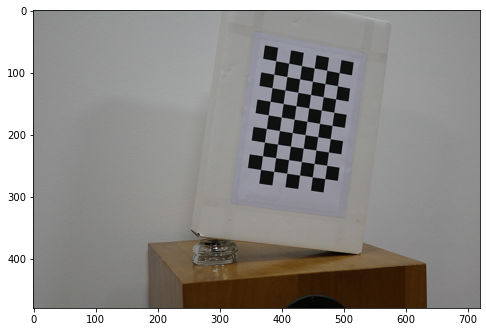

In [16]:
plt.figure(figsize=(8,8))
plt.imshow(cv2.imread('left12.jpg')[...,::-1])
plt.show()

Images tend to be affected by two different "kinds" of distortion:
 * Radial distortion: lines far from the principal point look distorted;
 * Tangential distortion: occurring because the len is not perfectly parallel to the camera plane.

**Radial distortion** is modeled using the following relationship between the undistorted coordinates $x_{u}$ and $y_{u}$ and the distorted ones $x$ and $y$:

\begin{equation}
x_{u} = x(1+k_1r^2+k_2r^4+k_3r^6) \\
y_{u} = y(1+k_1r^2+k_2r^4+k_3r^6)
\end{equation}

where $r$ is the "radius" of the point, (i.e., its distance from the principal point):
\begin{equation}
r^2=(x-o_{x})^2+(y-o_{y})^2
\end{equation}

**Tangential distortion** is modeled using the following relationship:

\begin{equation}
x_u = x+[2p_1 xy+p_2(r^2+2x^2)\\
y_u = y+[p_1(r^2+2y^2)+2p_2xy)
\end{equation}

In sum, we need five parameters to model camera distortion: $[k_1,k_2,k_3,p_1,p_2]$, which are the five values returned by the function _cv2.calibrateCamera_ in the _dist_ variable. 

The image can be rectified using the <a href="http://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#cv2.undistort">cv2.undistort</a> function:

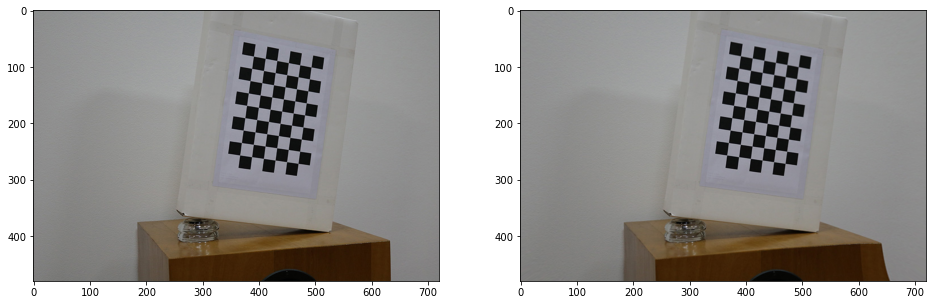

In [17]:
im=cv2.imread('left12.jpg')[...,::-1]
im_undistorted=cv2.undistort(im, mtx, dist)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(im_undistorted)
plt.show()

The quality of the lens on the camera, although a standard 18-55mm by Canon, and also the position of the checkerboard could not allow us to spot differences between the original picture and the rectified one (but take a look at the bottom right corner of the wood box).

# 3. Stereovision

Calibration of a stereo system means finding the essential matrix and the fundamental matrix of the system. To calibrate the camera, we need to find corresponding points in left-right image pairs using the already seen cv2.findChessboardCorners function.

## 3.1 Calibration
First, we need to collect all corners from right and left images:

In [18]:
all_right_corners=[]
all_left_corners=[]
all_3d_points=[]
idx=[1, 3, 6, 12, 14] #we use only some image pairs
idx = [1,2,3,4,5,6,7,8,9,11,12,13,14] # test with more images and check the reprojection error
valid_idxs=[] #we will also keep an list of valid indices, i.e., indices for which the procedure succeeded
for i in idx:
   #print(i)
    im_left=cv2.imread("left%02d.jpg"%i) #load left and right images 
    im_right=cv2.imread("right%02d.jpg"%i)
    
    ret_left,left_corners=cv2.findChessboardCorners(im_left,(9,6))
    ret_right,right_corners=cv2.findChessboardCorners(im_right,(9,6))
    
    
    if ret_left and ret_right: #if both extraction succeeded
        valid_idxs.append(i)
        all_right_corners.append(right_corners)
        all_left_corners.append(left_corners)
        all_3d_points.append(world_points) #3D points of the 7x6 pattern are always the same

The corners variable contains 54 vectors of dimension 1×2 as in the left camera. Each vector represents the coordinates of a detected corner. For example we can see the values of the first corner as follows:

In [19]:
print("Left camera corners detected: ", all_left_corners[0].shape)
print("Right camera corners detected: ", all_right_corners[0].shape)

print("Values of the first corner on the right camera: ", all_right_corners[0].reshape(-1,2)[0])

Left camera corners detected:  (54, 1, 2)
Right camera corners detected:  (54, 1, 2)
Values of the first corner on the right camera:  [356.4027 209.7391]


To calibrate the stereo system we now use the <a href="http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.stereoCalibrate">cv2.stereoCalibrate</a> function.
The function requires the following inputs:
 * `all_3d_points`: list of 3D points;
 * `all_left_corners`: list of corresponding 2D points in the first image (left image);
 * `all_right_corners`: list of corresponding 2D points in the second image (right image);
 * `(im.shape[1],im.shape[0])`: image size (width,height);
 * `mtx`: matrix of intrinsic parameters for the first image (left image);
 * `dist`: matrix of distoriton parameters for the first image (left image);
 * `mtx`: matrix of intrinsic parameters for the second image (right image). We assume these parameters to the same of the first image;
 * `dist`: matrix of distoriton parameters for the second image (right image). We assume these parameters to the same of the first image;
 * flag cv2.cv.CALIB_FIX_INTRINSIC to tell the system to use the precomputed instrinsic parameters.

In [20]:
retval, _, _, _, _, R, T, E, F=cv2.stereoCalibrate(all_3d_points,  all_left_corners, all_right_corners, mtx,dist,mtx,dist,(im.shape[1],im.shape[0]),flags=cv2.CALIB_FIX_INTRINSIC)
#Check the mean reprojection error
print(retval)

1.8273081247245633


The function returned the following values:

 * `retval`: mean reprojection error;
 * `cameraMatrix1`, `distCoeffs1`, `cameraMatrix2`, `distCoeffs2`: we are discarding these values because they would be equal to `mtx` and `dist`;
 * `R`: output rotation matrix between the 1st and the 2nd camera coordinate systems;
 * `T`: output translation vector between the coordinate systems of the cameras;
 * `E`: essential matrix
 * `F`: fundamental matrix
 
As we can see the mean reprojection error is high, with a value of 1.82 (the lower the better).

## 3.2 Epipolar Lines
Let's consider a given pair of stereo images, given a point on the left image, the matching point in the right one will lie on the corresponding epipolar line. In general, for each point in **one of the two images** it is possible to find the corresponding epipolar line in **the other image**. Let's consider for instance the first corner detected in the left image and its corresponding point in the right one:

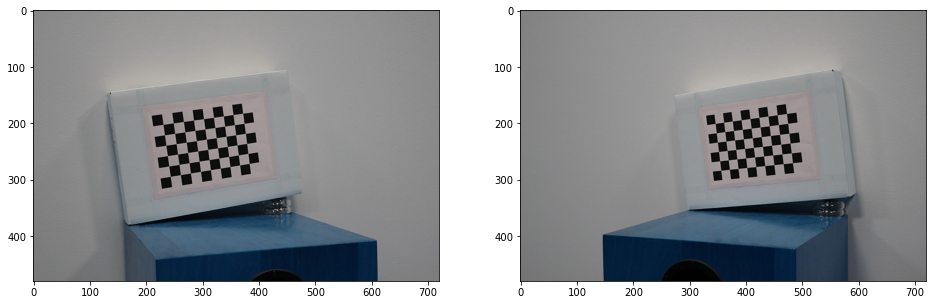

In [21]:
selected_image=2
left_im=cv2.imread("left%02d.jpg"%valid_idxs[selected_image])
right_im=cv2.imread("right%02d.jpg"%valid_idxs[selected_image])
left_corners=all_left_corners[selected_image].reshape(-1,2)
right_corners=all_right_corners[selected_image].reshape(-1,2)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(left_im)
plt.subplot(122)
plt.imshow(right_im)
plt.show()

<ipython-input-22-49baacb496c6>:1: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(left_im,(left_corners[0,0],left_corners[0,1]),10,(0,0,255),10)
<ipython-input-22-49baacb496c6>:2: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(right_im,(right_corners[0,0],right_corners[0,1]),10,(0,0,255),10)


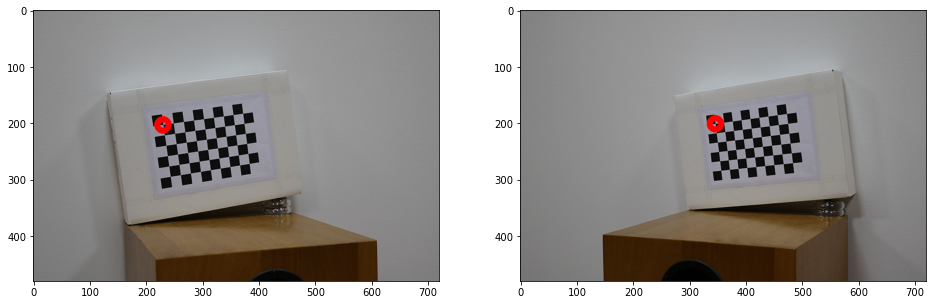

In [22]:
cv2.circle(left_im,(left_corners[0,0],left_corners[0,1]),10,(0,0,255),10)
cv2.circle(right_im,(right_corners[0,0],right_corners[0,1]),10,(0,0,255),10)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(left_im[...,::-1])
plt.subplot(122)
plt.imshow(right_im[...,::-1])
plt.show()

We can compute the epipolar lines corresponding to points of the left image using the function <a href="http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv.ComputeCorrespondEpilines">cv2.computeCorrespondEpilines</a>. The lines will lie on the right image:

In [23]:
lines_right = cv2.computeCorrespondEpilines(all_left_corners[selected_image], 1,F)

print(lines_right.shape)
lines_right=lines_right.reshape(-1,3) #reshape for convenience

(54, 1, 3)


Note that, apart from the corners and fundamental matrix, we had to specify an index "1" to signal that points belong to the first (left) image. Each of the $54$ lines of `lines_right` contains three values, specifying the coefficients of the equation:

\begin{equation}
ax+by+c=0
\end{equation}

To simplify the visualization of such lines, we can write the following function:

In [24]:
def drawLine(line,image,line_color):
    a=line[0]
    b=line[1]
    c=line[2]
    
    x0,y0 = map(int, [0, -c/b ])
    x1,y1 = map(int, [image.shape[1], -(c+a*image.shape[1])/b ])
   
    #draw the line
    cv2.line(image,(x0,int(y0)),(x1,int(y1)),line_color,3)#draw the image in yellow with line_width=3

We can now use the function to draw the corresponding epipolar line:

720


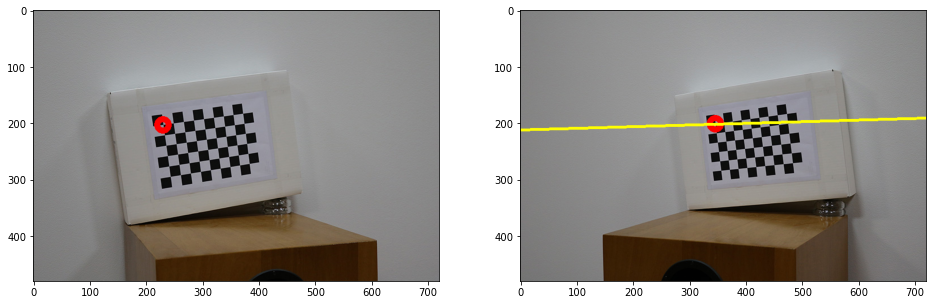

In [25]:
drawLine(lines_right[0],right_im,(0,255,255))

print(right_im.shape[1])
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(left_im[...,::-1])
plt.subplot(122)
plt.imshow(right_im[...,::-1])
plt.show()

Let's now compute the epipolar lines for the left image and print the first of them:

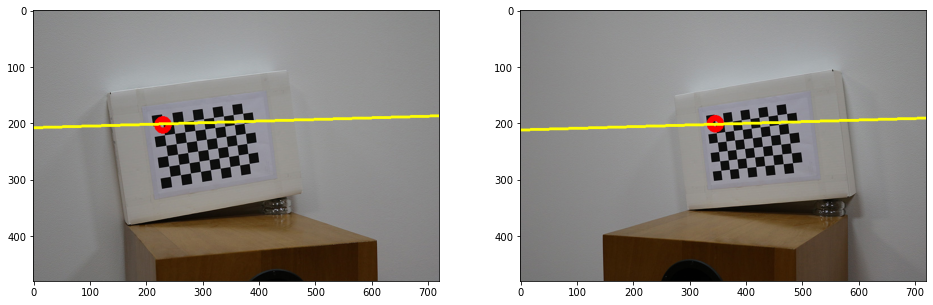

In [26]:
lines_left = cv2.computeCorrespondEpilines(all_right_corners[selected_image], 2,F)

lines_left=lines_left.reshape(-1,3)

drawLine(lines_left[0],left_im,(0,255,255))

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(left_im[...,::-1])
plt.subplot(122)
plt.imshow(right_im[...,::-1])
plt.show()

As we can see the epipolar line seems to be correctly aligned between the two pictures of left and right camera, meaning that the matching is pretty good.
To improve the correspondence we can use higher resolution images and improve the cameras position on the scene.

# References
 [1] Camera calibration tutorial for Python+OpenCV: 
 http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration
 
 [2] OpenCv, Checkerbord pattern: https://github.com/opencv/opencv/blob/master/doc/pattern.png.
 
 [3] Canon EOS 750D: https://en.wikipedia.org/wiki/Canon_EOS_750D